In [54]:
%load_ext autoreload
%autoreload 2
import rasterio 
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
os.chdir("/scratch/ewalt/pdm/rs-uncertainty/")
from src.viz import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
random.seed(123)

In [3]:
RESDIR = "results/cloud_exp/2023-06-20_16-14-11"
S2DIR = "gee_data/reprojected/"
S2REPRDIR = "gee_data/reprojected_dirs"
GTDIR = "assets/data/preprocessed"
SANITYRESDIR = "results/cloud_exp/2023-05-31_11-23-56_sanity_check" # results
SANITYS2DIR = "assets/data/sentinel_data/s2_reprojected" # s2 reprojected
SANITYS2REPRDIR = "gee_data/sanity_check/" # restructured s2 reprojected
SPLITMASKDIR = "assets/data/split_masks/" # split masks
SHAPEFILES = ['assets/data/NHM_projectDekning_AOI_edit2015_V2.shp', 'assets/data/ALS_projects_Dz_all_norway.shp']

In [4]:
VARIABLES = ['P95', 'MeanH', 'Dens', 'Gini', 'Cover']

In [5]:
islice, jslice = slice(470, 600), slice(150, 300)

In [6]:
# result_dirs = [p.path for p in 
#                os.scandir("/scratch/ewalt/pdm/rs-uncertainty/results/cloud_exp/2023-06-20_16-14-11")]
# Experiment result directories
result_dirs = [p.path for p in os.scandir(RESDIR) if os.path.exists(os.path.join(p.path,"rcu.json"))]
len(result_dirs)

72

In [7]:
_, result_dirs = filterZeroAvgCp(result_dirs, S2REPRDIR)

In [8]:
len(result_dirs)

71

In [9]:
def selectRandom(ls, length):
    ls_ = ls.copy()
    random.shuffle(ls_)
    return ls_[:length]

In [56]:
img_path, gt_path, variance_path, aleatoric_path = getPaths(
    result_dirs[0], S2REPRDIR, GTDIR, ["img", "gt", "variance", "aleatoric"]
)

In [ ]:
        if normalize:
            orig_mean, gee_mean, orig_predictive_std, gee_predictive_std = multiNorm2d(orig_mean, gee_mean, orig_predictive_std, gee_predictive_std)
            vmin, vmax = 0, 1
        else:
            vmin, vmax = multiMinMax(orig_mean, gee_mean, orig_predictive_std, gee_predictive_std)
        dvmin, dvmax = vmin-vmax, vmax-vmin

In [ ]:
        # paths
        gee_mean_path, gee_variance_path = getPaths(gee_dir, returns=["mean", "variance"])
        orig_mean_path, orig_variance_path = getPaths(orig_dir, returns=["mean", "variance"])
        # means
        gee_mean = loadRaster(gee_mean_path, bands=variable_index, islice=islice, jslice=jslice)
        orig_mean = loadRaster(orig_mean_path, bands=variable_index, islice=islice, jslice=jslice)
        # variances
        gee_variance = loadRaster(gee_variance_path, bands=variable_index, islice=islice, jslice=jslice)
        orig_variance = loadRaster(orig_variance_path, bands=variable_index, islice=islice, jslice=jslice)

In [ ]:
    # Load data
    orig_mean = loadRaster(orig_path, bands=variable_index)
    gee_mean = loadRaster(gee_path, bands=variable_index)

In [ ]:
        img_path, mean_path, variance_path, gt_path = getPaths(d, s2repr_dirs, gt_dir, returns=["img","mean","variance","gt"])
        # load rasters
        rgb = loadRaster(img_path, bands=[4,3,2], transpose_order=(1,2,0), islice=islice, jslice=jslice)
        gt = loadRaster(gt_path, bands=variable_index, islice=islice, jslice=jslice, set_nan_mask=True)
        if variable_index in [3,5]: gt /= 100 # Cover/Dens normalization!!
        mean = loadRaster(mean_path, bands=variable_index, islice=islice, jslice=jslice)
        variance = loadRaster(variance_path, bands=variable_index, islice=islice, jslice=jslice)

In [ ]:
        mean_path, variance_path, gt_path = getPaths(d, gt_dir, returns=["mean","variance","gt"])
        # load rasters
        gt = loadRaster(gt_path, bands=variable_index, islice=islice, jslice=jslice, set_nan_mask=True)
        if variable_index in [3,5]: gt /= 100 # Cover/Dens normalization!!
        mean = loadRaster(mean_path, bands=variable_index, islice=islice, jslice=jslice)
        variance = loadRaster(variance_path, bands=variable_index, islice=islice, jslice=jslice)

In [ ]:
def getPaths(
    src_dir, 
    s2repr_dirs=None, 
    gt_dir=None,
    returns=None
):
    src_dir = str(src_dir)
    if returns is None:
        return
    rname = lambda x: "_".join(Path(x).stem.split("_")[1:])
    valid_returns = ["img", "gt"] + [rname(p.path) for p in os.scandir(src_dir)]
    # start logic
    dir_name = src_dir.split("/")[-1]
    pid = dir_name.split("_")[0]
    retuple = []
    for r in returns: 
        assert r in valid_returns
        if r=="img":
            assert s2repr_dirs is not None, "must provide s2repr_dirs to get img"
            retuple.append(
                list(Path(os.path.join(s2repr_dirs, dir_name, pid)).glob("*.tif"))[0]
            )
        elif r=="gt":
            assert gt_dir is not None, "must provide gt_dir to get gt"
            retuple.append(os.path.join(gt_dir, f"{pid}.tif"))
        else:
            retuple.append(os.path.join(src_dir, f"{pid}_{r}.tif"))
        assert os.path.exists(retuple[-1])
    return tuple(retuple)

In [58]:
def loadRaster(
    path,
    bands=None, # set to None for all bands, -1 for last one
    islice=None,
    jslice=None,
    clip_range=None,
    transpose_order=None,
    set_nan_mask=False, # for gt
    dtype=None,
    elementwise_fn=None
):
    with rasterio.open(path) as f:
        if bands is None: bands = f.indexes
        if bands == -1: bands = f.count
        x = f.read(bands)
        if set_nan_mask:
            mask = f.read_masks(1)
            x[mask==0] = np.nan
        if islice is not None:
            if isinstance(bands, list): x = x[:,islice]
            else: x = x[islice]
        if jslice is not None:
            if isinstance(bands, list): x = x[:,:,jslice]
            else: x = x[:,jslice]
        if clip_range is not None: x = clp(x, clip_range)
        if transpose_order is not None: x = x.transpose(*transpose_order)
        if dtype is not None: x = x.astype(dtype)
        if elementwise_fn is not None: x = elementwise_fn(x)
    return x

In [59]:
loadRaster(img_path, [4,3,2], transpose_order=(1,2,0)).shape

array([[[   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        ...,
        [ 230,  338,  287],
        [ 213,  304,  275],
        [ 228,  309,  261]],

       [[   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        ...,
        [ 236,  346,  288],
        [ 229,  322,  266],
        [ 216,  335,  274]],

       [[   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        ...,
        [ 243,  354,  320],
        [ 244,  338,  324],
        [ 215,  310,  298]],

       ...,

       [[4420, 3768, 3408],
        [4516, 4124, 3898],
        [5312, 4984, 4620],
        ...,
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0]],

       [[3898, 3582, 3354],
        [4396, 4180, 4108],
        [5196, 4856, 4552],
        ...,
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0]],

       [[3720, 3610, 3532],
        [4408, 4256, 4248],
        [5048, 4

# Get not too cloudy projects

In [61]:
tuple([1, 2, 3])

(1, 2, 3)

In [10]:
"""
['results/cloud_exp/2023-06-20_16-14-11/1023_20180421T105031',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180804T105019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180508T104031',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180705T105029',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180725T105029',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180612T104019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180928T105021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180418T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180903T105019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180715T105029']
"""
None

In [11]:
def filterDirectoriesByAverageCp(dirs, s2repr_dirs, threshold, islice=None, jslice=None, max_samples=None):
    selection = []
    for d in dirs:
        dir_name = d.split("/")[-1]
        pid = dir_name.split("_")[0]
        img_path = list(Path(os.path.join(s2repr_dirs, dir_name, pid)).glob("*.tif"))[0]
        with rasterio.open(img_path) as f:
            cp  = f.read(f.count)
            if islice is not None: cp = cp[islice,:]
            if jslice is not None: cp = cp[:,jslice]
        if np.nanmean(cp) > threshold: continue
        selection.append(d)
    if max_samples is not None:
        selection = selectRandom(selection, max_samples)
    return selection

In [12]:
cloudless_dirs = filterDirectoriesByAverageCp(result_dirs, S2REPRDIR, 10, islice, jslice, 10)

In [13]:
len(cloudless_dirs)

10

In [14]:
"""
['results/cloud_exp/2023-06-20_16-14-11/1023_20180421T105031',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180804T105019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180508T104031',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180705T105029',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180725T105029',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180612T104019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180928T105021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180418T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180903T105019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180715T105029']
"""
cloudless_dirs = selectRandom(cloudless_dirs, 10)

In [15]:
len(cloudless_dirs)

10

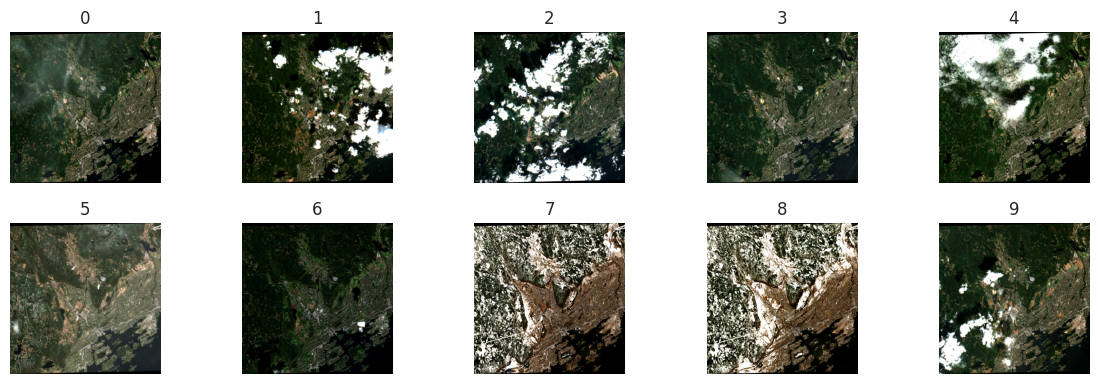

In [16]:
showRGB(cloudless_dirs, S2REPRDIR, nrows=2)

In [17]:
cloudless_dirs

['results/cloud_exp/2023-06-20_16-14-11/1023_20180715T105029',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180804T105019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180903T105019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180705T105029',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180612T104019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180508T104031',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180928T105021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180421T105031',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180418T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180725T105029']

# Random selection

In [18]:
"""
['results/cloud_exp/2023-06-20_16-14-11/1023_20180428T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180801T104019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180617T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180913T105019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180918T105021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180526T105029',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180630T105031',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180607T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180826T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180925T104021']
"""
None

In [19]:
random_dirs = selectRandom([rd for rd in result_dirs if rd not in cloudless_dirs], 15)

In [20]:
len(random_dirs)

15

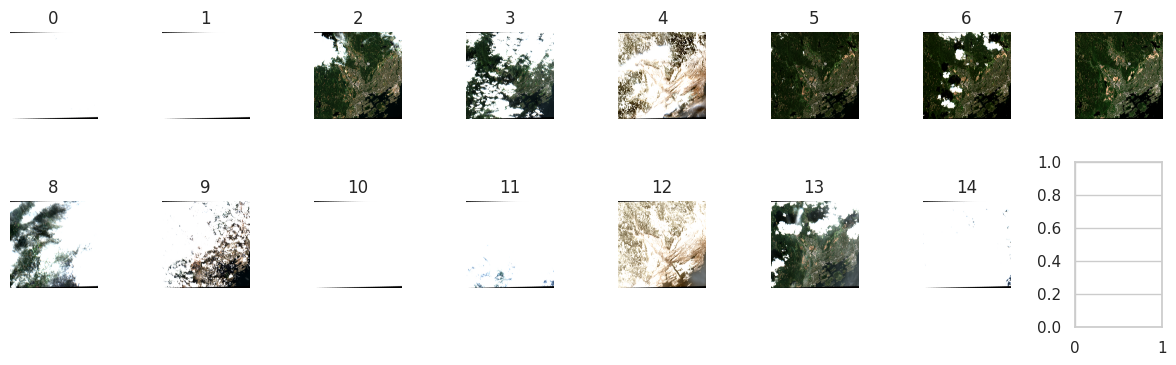

In [21]:
showRGB(random_dirs, S2REPRDIR, nrows=2)

In [22]:
random_dirs = [rd for i, rd in enumerate(random_dirs) 
               if not i in [3, 13, 14]]

In [23]:
len(random_dirs)

12

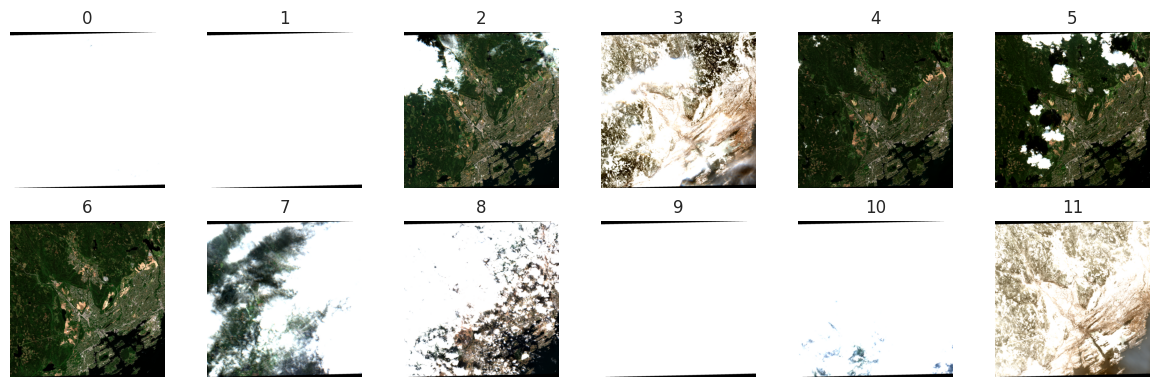

In [24]:
showRGB(random_dirs, S2REPRDIR, nrows=2)

In [25]:
random_dirs

['results/cloud_exp/2023-06-20_16-14-11/1023_20180905T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180816T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180712T104019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180413T104019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180831T104019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180826T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180518T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180923T105019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180428T104021',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180503T104019',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180511T105031',
 'results/cloud_exp/2023-06-20_16-14-11/1023_20180411T105031']

## Sort by gap

In [26]:
def sortByAleatoricEpistemicGap(dirs, islice=None, jslice=None, max_samples=None, func=np.nanmean, **func_kw):
    gaps = [[] for _ in range(5)]
    for d in dirs:
        dir_name = d.split("/")[-1]
        pid = dir_name.split("_")[0]
        aleatoric_path = Path(os.path.join(d, f"{pid}_aleatoric.tif"))
        epistemic_path = Path(os.path.join(d, f"{pid}_epistemic.tif"))
        with rasterio.open(aleatoric_path) as f:
            aleatoric = f.read(f.indexes)
            if islice is not None and jslice is not None:
                aleatoric = aleatoric[:,islice, jslice]
        with rasterio.open(epistemic_path) as f:
            epistemic = f.read(f.indexes)
            if islice is not None and jslice is not None:
                epistemic = epistemic[:,islice, jslice]
        for i in range(5):
            gaps[i].append(func(aleatoric[i], **func_kw)-func(epistemic[i], **func_kw))
    sorted_dirs = [dirs.copy() for _ in range(5)]
    for i in range(5):
        gaps[i], sorted_dirs[i] = list(map(list,list(zip(*sorted(zip(gaps[i], sorted_dirs[i]), key=lambda x:x[0], reverse=True)))))
        if max_samples is not None:
            selection = selectRandom(list(range(len(gaps[i]))), max_samples)
            gaps[i] = [gap for j, gap in enumerate(gaps[i]) if j in selection]
            sorted_dirs[i] = [gap for j, gap in enumerate(sorted_dirs[i]) if j in selection]
    return sorted_dirs, gaps

In [27]:
gapsort_dirs, gaps = sortByAleatoricEpistemicGap(result_dirs, islice, jslice, func=np.nanpercentile, q=95)

In [28]:
gapsort_dirs, gaps

([['results/cloud_exp/2023-06-20_16-14-11/1023_20180617T104021',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180501T105031',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180506T105029',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180809T105031',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180707T104021',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180508T104031',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180920T104019',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180725T105029',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180918T105021',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180910T104019',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180925T104021',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180615T105029',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180821T104019',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180612T104019',
   'results/cloud_exp/2023-06-20_16-14-11/1023_20180903T105019',
   'results/cloud_exp/202

P95


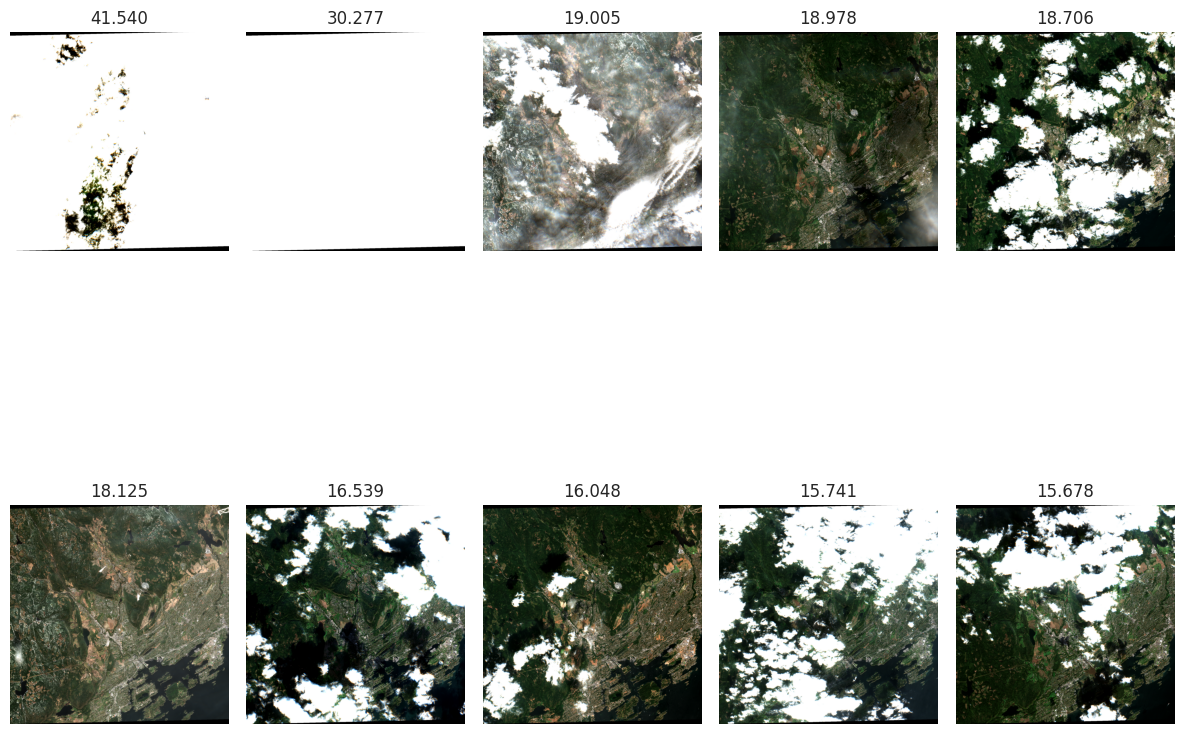

MeanH


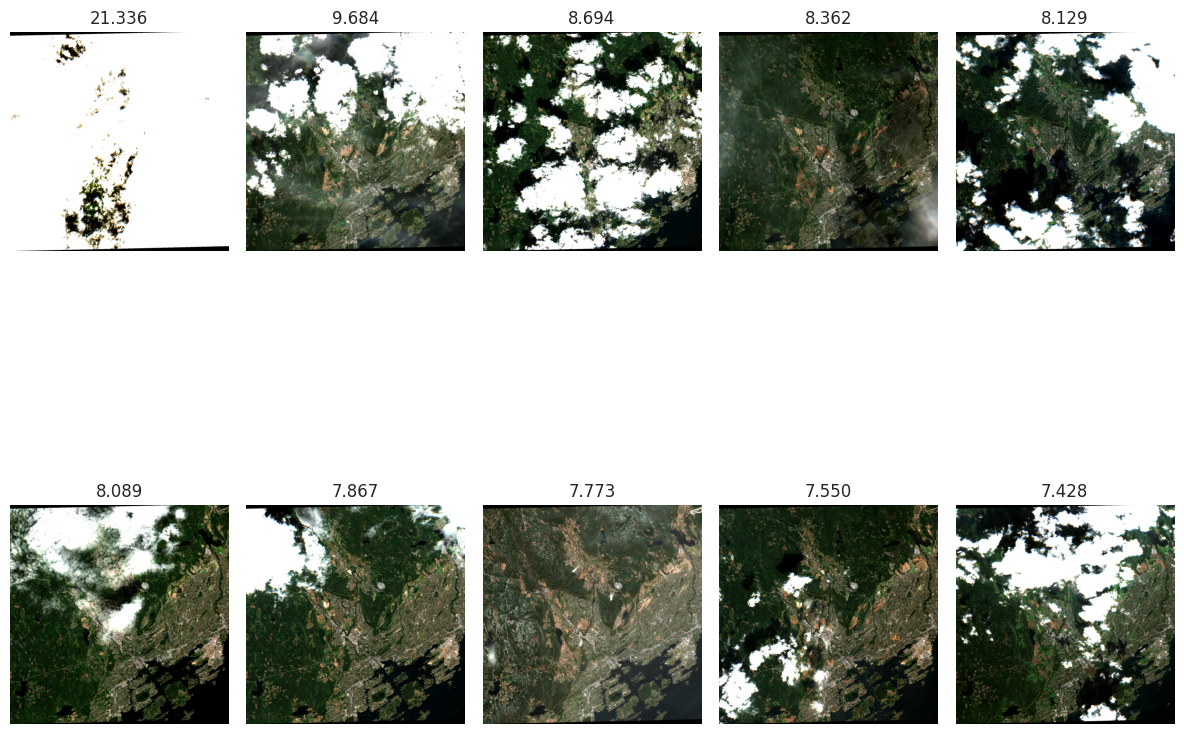

Dens


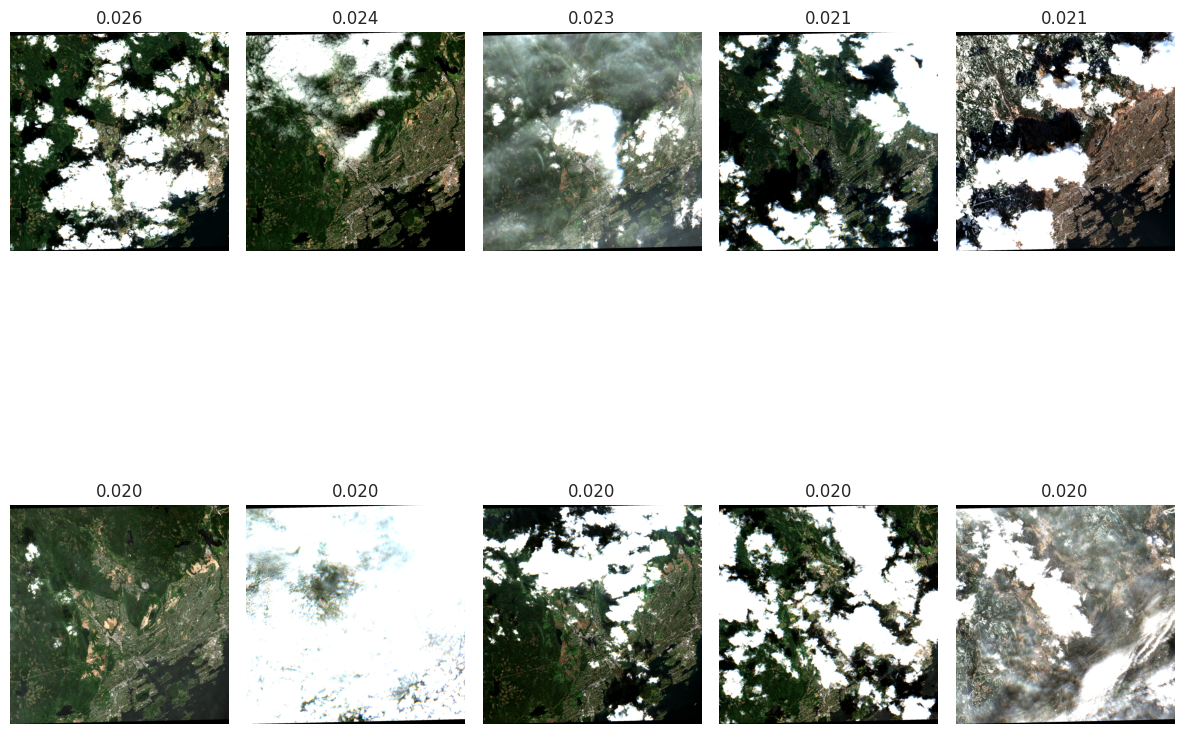

Gini


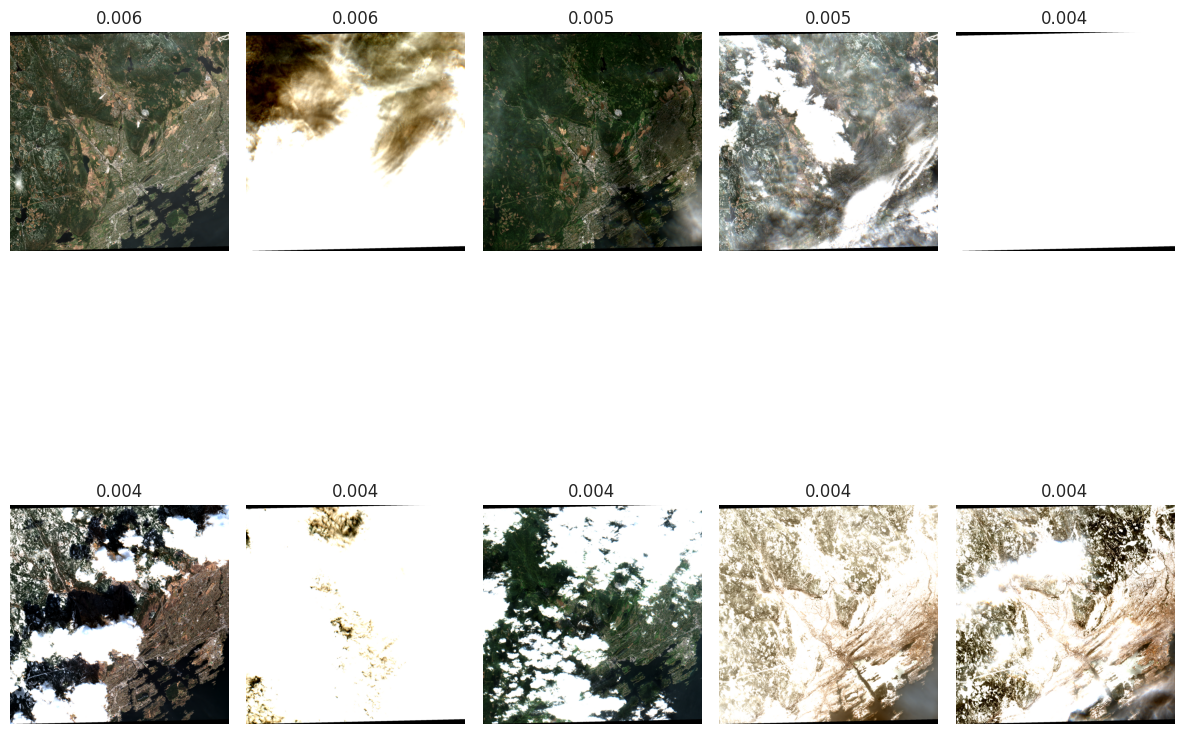

Cover


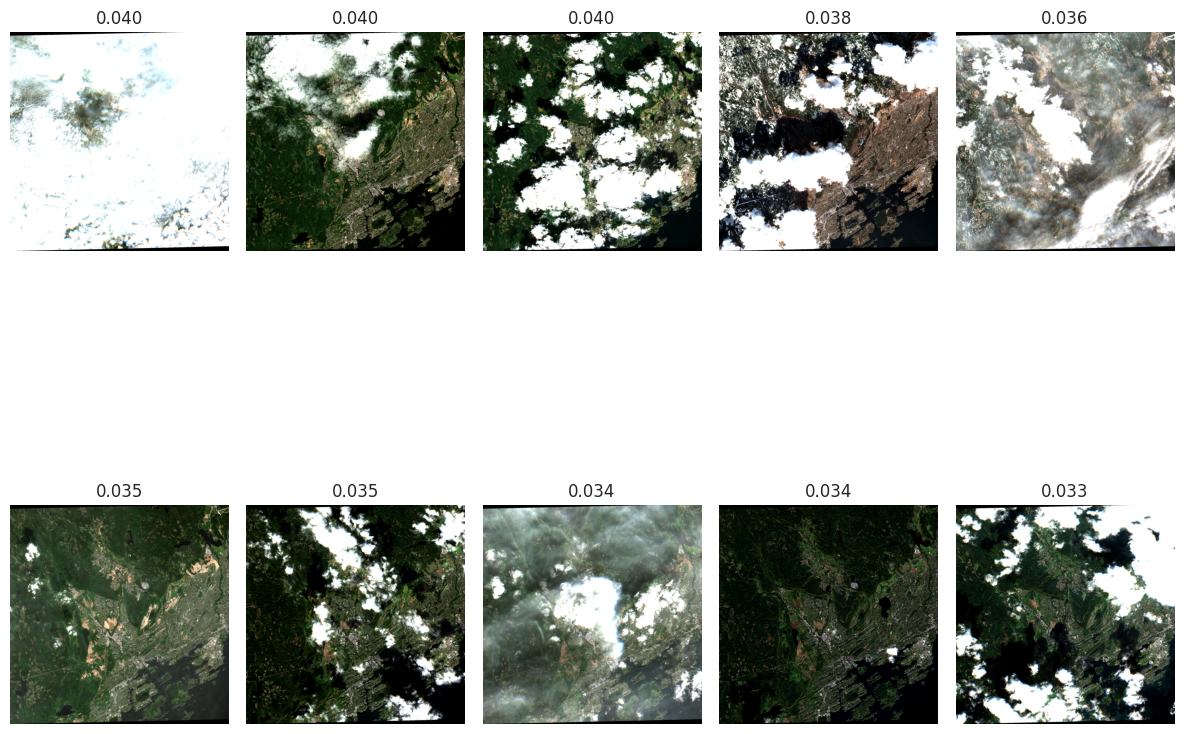

In [29]:
for i in range(5):
    print(VARIABLES[i])
    showRGB(gapsort_dirs[i][:10], S2REPRDIR, titles=[f"{g:.3f}" for g in gaps[i][:10]], nrows=2, figsize=(12,12))

# Matching dirs

In [30]:
matching_dirs = []
for orig_dir in os.scandir(SANITYRESDIR):
    for gee_dir in os.scandir(RESDIR):
        if orig_dir.name == gee_dir.name:
            matching_dirs.append((orig_dir, gee_dir))

In [31]:
gee_matching_dirs = [d.path for _, d in matching_dirs]

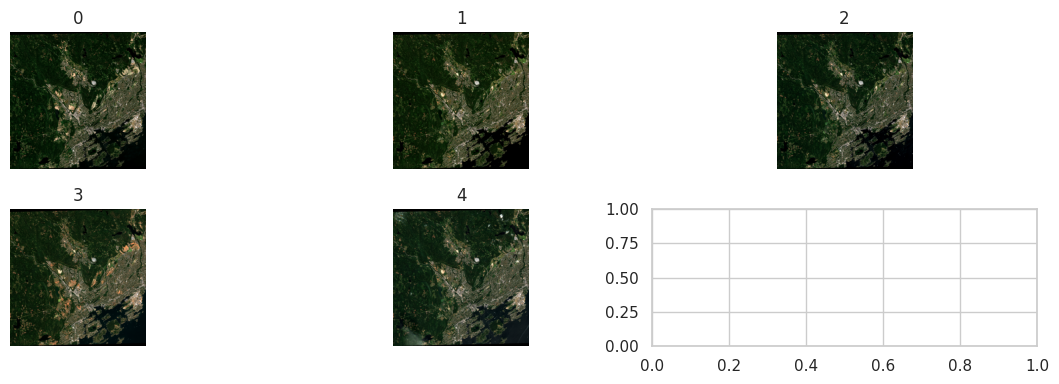

In [32]:
showRGB(gee_matching_dirs, S2REPRDIR, nrows=2)

In [33]:
gee_matching_dirs

NameError: name 'gee_matchin_dirs' is not defined

# 4 conditions

In [ ]:
selected_result_dirs = [os.path.join(RESDIR,'1023_20180702T104019'),
 os.path.join(RESDIR,'1023_20180925T104021'),
 os.path.join(RESDIR,'1023_20180918T105021'),
 os.path.join(RESDIR,'1023_20180528T104021')]

In [ ]:
showRGB(selected_result_dirs , S2REPRDIR)

In [ ]:
selected_result_dirs 

# Inspect uncertainties

In [ ]:
# Uncertainty type sanity check
def clip(arr, bounds):
    bounds = (float(bounds[0]), float(bounds[1]))
    arr = np.where(arr>bounds[1], bounds[1], arr)
    arr = np.where(arr<bounds[0], bounds[0], arr)
    arr -= bounds[0]
    arr /= (bounds[1]-bounds[0])
    return arr

def norm2d(x, mn=None, mx=None, a=0, b=1): 
    if mn is None: mn = np.nanmin(x)
    if mx is None: mx = np.nanmax(x)
    return (b-a)*(x-mn)/(mx-mn)+a

def showUncertaintyType(
    dirs,
    s2repr_dirs,
    titles,
    variable_name, 
    variable_index,
    islice=None,
    jslice=None,
    save_name=None,
    figsize=(12,20),
    normalize=True
):
    if titles is not None:
        assert isinstance(titles, list) and len(titles)==len(dirs)
    fig, axs = plt.subplots(ncols=4, nrows=len(dirs), figsize=figsize)
    for i, d in enumerate(dirs):
        dir_name = d.split("/")[-1]
        pid = dir_name.split("_")[0]
        img_path = list(Path(os.path.join(s2repr_dirs, dir_name, pid)).glob("*.tif"))[0]
        aleatoric_path = Path(os.path.join(d, f"{pid}_aleatoric.tif"))
        epistemic_path = Path(os.path.join(d, f"{pid}_epistemic.tif"))
        predictive_path = Path(os.path.join(d, f"{pid}_variance.tif"))
        with rasterio.open(img_path) as f:
            rgb = f.read([4,3,2])
            if islice is not None and jslice is not None:
                rgb = rgb[:,islice, jslice]
            rgb = clip(rgb, (0,3000))
            rgb = rgb.transpose(1,2,0)
        with rasterio.open(aleatoric_path) as f:
            aleatoric = np.sqrt(f.read(variable_index))
            if islice is not None and jslice is not None:
                aleatoric = aleatoric[islice, jslice]
        with rasterio.open(epistemic_path) as f:
            epistemic = np.sqrt(f.read(variable_index))
            if islice is not None and jslice is not None:
                epistemic = epistemic[islice, jslice]
        with rasterio.open(predictive_path) as f:
            predictive = np.sqrt(f.read(variable_index))
            if islice is not None and jslice is not None:
                predictive = predictive[islice, jslice]
        lo = min(np.nanmin(x) for x in [aleatoric, epistemic, predictive])
        hi = max(np.nanmax(x) for x in [aleatoric, epistemic, predictive])
        if normalize:
            aleatoric = norm2d(aleatoric, lo, hi, a=lo, b=hi)
            epistemic = norm2d(epistemic, lo, hi, a=lo, b=hi)
            predictive = norm2d(predictive, lo, hi, a=lo, b=hi)
        axs[i,0].imshow(rgb)
        sns.heatmap(aleatoric, ax=axs[i,1], vmin=lo, vmax=hi)#, vmin=0, vmax=1)
        sns.heatmap(epistemic, ax=axs[i,2], vmin=lo, vmax=hi)#, vmin=0, vmax=1)
        sns.heatmap(predictive, ax=axs[i,3], vmin=lo, vmax=hi)#, vmin=0, vmax=1)
        if i==0:
            axs[i,0].set_title("rgb")
            axs[i,1].set_title("aleatoric")
            axs[i,2].set_title("epistemic")
            axs[i,3].set_title("predictive")
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    if titles is not None:
        for i, title in enumerate(titles):
            axs[i,0].set_ylabel(title)
    fig.suptitle(variable_name)
    plt.tight_layout()
    if save_name is not None: savefig(fig, save_name)
    plt.show()

In [ ]:
def uncertaintyViz(dirs):
    for i, variable_name in enumerate(VARIABLES):
        showUncertaintyType(
            dirs, 
            S2REPRDIR, 
            None, 
            variable_name, 
            i+1, 
            islice, jslice, 
            figsize=(12,2*len(dirs))
        )

## "Cloudless" images

In [ ]:
uncertaintyViz(cloudless_dirs)

## Random images

In [ ]:
uncertaintyViz(random_dirs)

## Sorted by q95

In [ ]:
uncertaintyViz(gapsort_dirs[0][:10])

In [ ]:
uncertaintyViz(gapsort_dirs[1][:10])

In [ ]:
uncertaintyViz(gapsort_dirs[2][:10])

In [ ]:
uncertaintyViz(gapsort_dirs[3][:10])

In [ ]:
uncertaintyViz(gapsort_dirs[4][:10])

## Matching dirs

In [ ]:
uncertaintyViz(gee_matching_dirs)

## 4 conditions

In [ ]:
uncertaintyViz(selected_result_dirs)